This notebook is devoted to perform hyperparameter tunning of a DDQN agent in order to solve a pretty basic environment as Cartpole-v0. Besides learning how different hyperparameters affect the learning curve of our agent, this project is aimed at sanity checking the implementation of my agent, which will be used later on to solve more complex environments.

In [1]:
import glob
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from utils import create_settings, create_key, save_data, solve_metric, load_agent_results, creage_avg, sns_lineplot
import seaborn as sns
import sys
sys.path.insert(1,'/home/axelbm23/Code/ML_AI/Algos/ReinforcementLearning/')
from agents import DDQN,Agent_Performance
import time
import tensorflow as tf
import tf_keras
from typing import Any,Optional

2024-07-22 15:05:03.270264: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 15:05:03.300597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 15:05:03.974891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We will conduct some analysis on four different parameters as they seem seem to be the ones that affect the results in a major degree. For each parameter, we will produce 3 runs, as RL algorithms are more heavily influenced by the initial conditions (i.e network weights) that other techniques. The parameters we will play with are:
1) complexity of the network, i.e number of layers and number of nodes per layer
2) Learning rate of our optimizer
3) batch size
4) type of update on the target network, either soft update or hard copy.
5) greedy step, i.e how large the exploratio phase is

In [2]:
# Set up the default values
N_ITERATIONS = 3
GAMMA = 0.99
GREEDY_STEP = 999e-3
EPISODES = 600
BUFF_SIZE = 1_000
BATCH_SIZE = 64
NN_COPY_CADENCY = 10
SOFT_UPDATE = 0.005
NEURONS = [128]*2
ACT_AS_IN = False
ADD_LOGS = False
LOSS_FUNC = 'mean_squared_error'
ADAM_LR = 0.001
OUTPUT_PATH = f'{os.getcwd()}/results/rewards_losses'
SOLVED = 195
OVERWRITE = False

# According to openai/gym/wiki
# Cartpole-v0 is solved when it reaches an average reward
# of 195 over 100 consecutive episodes
env = gym.make("CartPole-v0")
def_nn_arch = {'neurons': NEURONS,
               'action_as_input':ACT_AS_IN,
                'loss_function': LOSS_FUNC,
                'optimizer': tf.keras.optimizers.Adam(learning_rate=ADAM_LR),
                }

def_agent = {'gamma': GAMMA,
            'greedy_step': GREEDY_STEP,
            'environment': env,
            'episodes': EPISODES,
            'buff_size': BUFF_SIZE, 
            'replay_mini_batch': BATCH_SIZE,
            'nn_copy_cadency': NN_COPY_CADENCY,
            'nn_architecture': def_nn_arch,
            'soft_update': SOFT_UPDATE,
            'add_logs':ADD_LOGS}

/home/axelbm23/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
2024-07-22 15:05:06.205889: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 15:05:06.247413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 15:05:06.247451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 15:05:06.251116: I external/local_xla/xla/stream_executor/cuda/c

In [3]:
# Create different settings for each one of the experiments
network_arch_sett = ([64]*2,[256]*4)
lr_sett = [0.1,0.05]
batch_siz_sett = [32,128]
target_update_sett = [(25, 0.01),(None,0.005), (None,0.01)]
greedy_step_sett = [99e-2, 9985e-4]
experiment = {'nn_arch':network_arch_sett,
               'lr':lr_sett,
               'target_update':target_update_sett,
               'greedy_step':greedy_step_sett,
               'default':[None]}

Train our agent for each set of parameters

In [4]:
total_experiments = N_ITERATIONS*sum([len(exp_i) for exp_i in experiment.values()])
if OVERWRITE:
   i = 0
   for key,val in experiment.items():
      for sett_i in val:
         sett_key = create_key(sett_i)
         for it in range(N_ITERATIONS):
            ag_sett = create_settings(key,sett_i,def_nn_arch, def_agent)
            model_label = f'{key}_{sett_key}_iter_{it}'if key!='default' else f'{key}_iter_{it}'
            # Initialize the class again as the network weights need to be random
            ddqn = DDQN(sett=ag_sett)
            t1 = time.time()
            rewards, losses, logs = ddqn.learn()
            exec_time = round(time.time()-t1, 3)
            
            # Save all the information we need for the post analysis,
            # basically execution time, rewards and losses
            save_data(rewards, losses, exec_time, model_label, OUTPUT_PATH)
            i += 1 
            print(f'Progress..{round(i/total_experiments,3)}')
            
   print(f'All data has been created')
else:
   print(f'Data already created will be loaded')

Data already created will be loaded


We will perform two tasks here. The first one will be to analyze the reward/loss function of each individual try of the algorithm to make some hypothesis about what is going on with it. The second part, will be to compute some performance metrics to quantify the algorithm performance across different dimensions.

In [5]:
results_dfs = load_agent_results(OUTPUT_PATH)

In [6]:
# Create statistics for all the experiments
stats = {}
for param, df in results_dfs.items():
    rew = df.groupby(['iter'])['rewards'].apply(lambda x: x.to_numpy())
    loss = df.groupby(['iter'])['losses'].apply(lambda x: x.to_numpy())
    ag_perf = Agent_Performance(rewards=rew, losses=loss, solved_func=solve_metric, solved_rew=SOLVED)
    stats[param] = ag_perf.compute_statistics(prec=3)
stats_df = pd.DataFrame.from_dict(stats).T
stats_df.sort_index(inplace=True)

### Greedy policy (~size of exploration phase) analysis ###

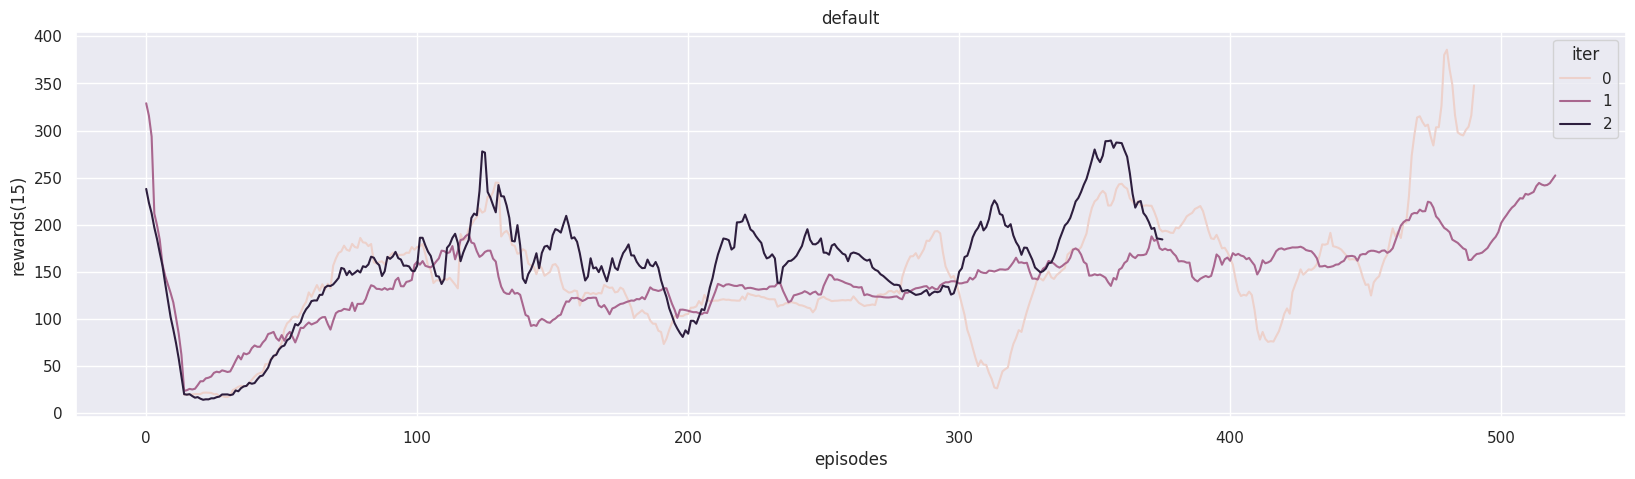

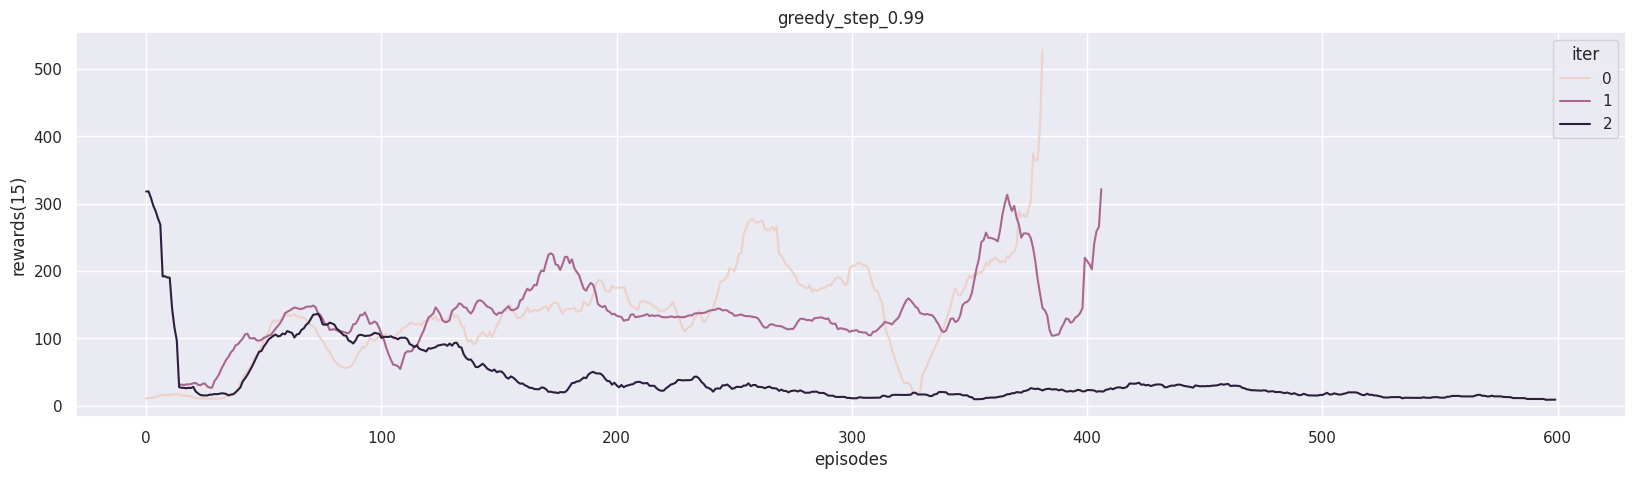

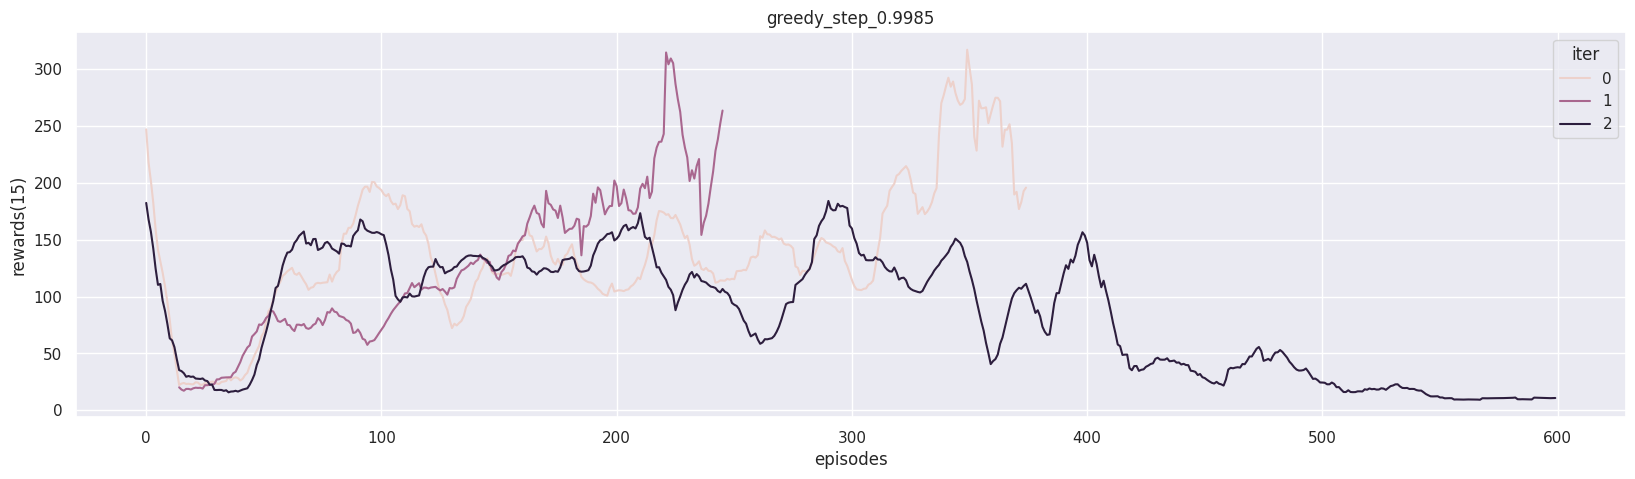

,avg_end_rew,best_worst_ratio_end_rew,avg_epi_rew,avg_epi_rew_increase,std_epi_rew_increase,n_solved,avg_ep_to_solve,max_drawdown
default,392.333,1.794,146.745,0.813,97.890,3.0,462.666667,709.000
greedy_step_0.99,983.333,187.300,97.292,2.072,102.442,2.0,394.500000,460.000
greedy_step_0.9985,154.667,25.333,108.611,0.310,104.824,2.0,310.500000,847.667


In [7]:
greedy_param = [x for x in stats_df.index if x.startswith('greedy') or x=='default']
greedy_stats = stats_df.loc[((stats_df.index.isin(greedy_param)) | (stats_df.index=='default')),:]
for param in greedy_param:
    df = results_dfs[param]
    df = creage_avg(df,'rewards',15)
    sns_lineplot(df, 'episodes', 'rewards(15)', 'iter', param)
greedy_stats

Higher values of greedy parameter result in bigger exploration phases, which ultimately led to more stable learning curves. The default setting is the one using the biggest greedy param (0.999) vs (0.99 and 0.9985). As it can be seen from the graphs above, the default settings lead to more robust learning, with all the three trials being able to solve the environment. This is also reflected in a lower value in "std_epi_rew_increase" value in the table above, which measures the standard deviation of the increase in reward per episode. Lower values on this metric indicate the average reward tends to deviate less form its mean.

Nevertheless, this higher robustness comes at a price, a higher average episode to solve the environment (avg_ep_to_solve column in the table above). The more room we give the algo to explore, the higher the chances to get the correct policy, but also the more freedom we are giving it to take "wrong decisions" early on, which increases the learning time.

### Network Architecture Analysis ###

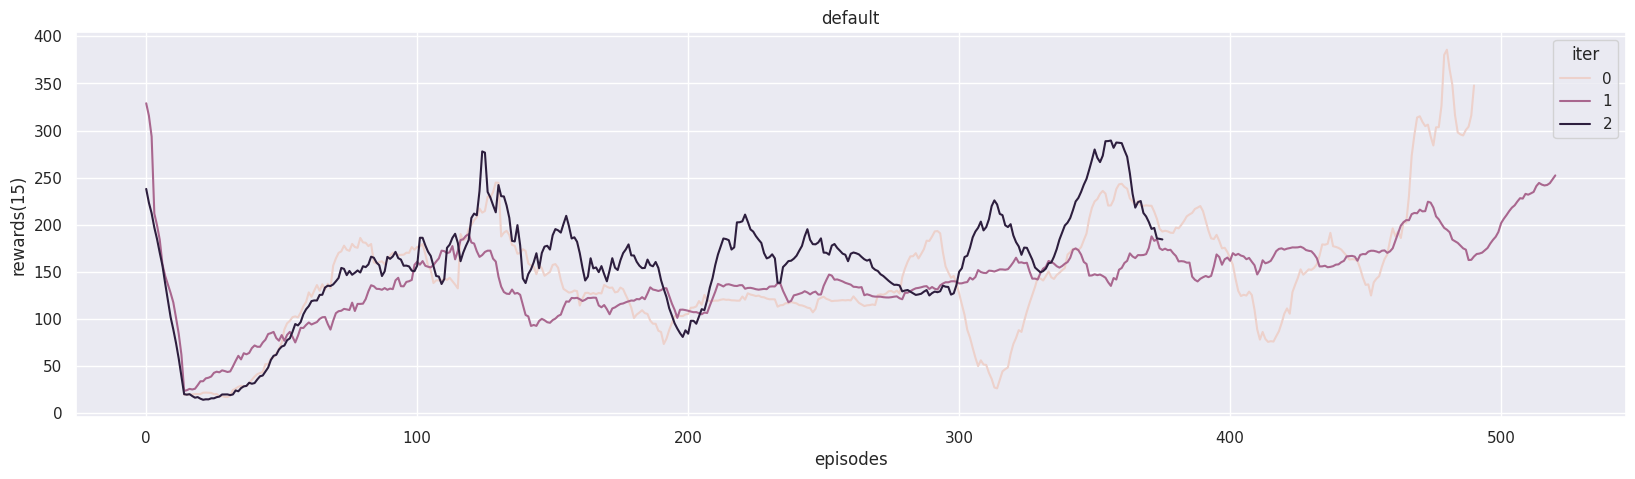

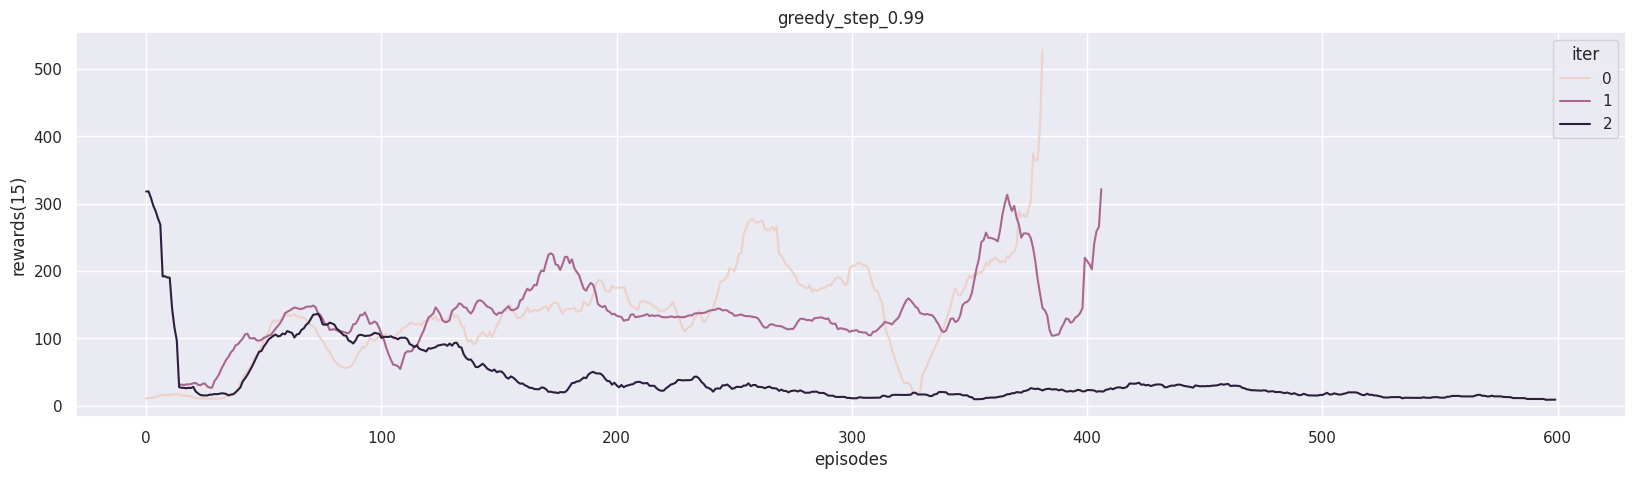

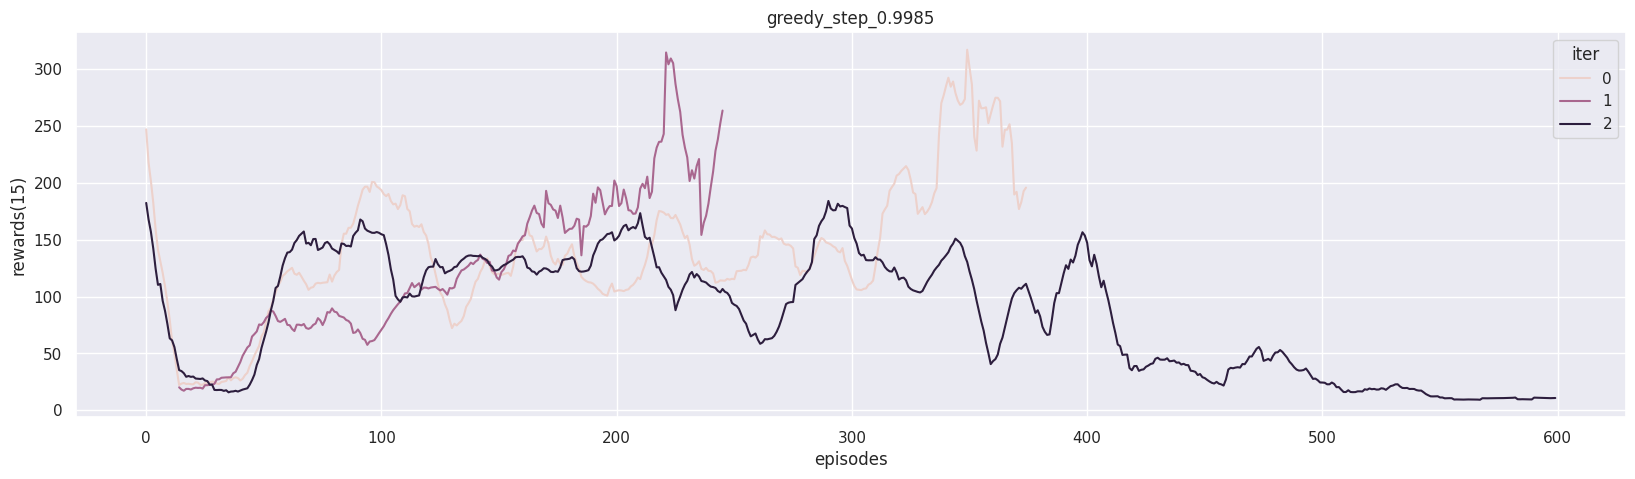

,avg_end_rew,best_worst_ratio_end_rew,avg_epi_rew,avg_epi_rew_increase,std_epi_rew_increase,n_solved,avg_ep_to_solve,max_drawdown
default,392.333,1.794,146.745,0.813,97.890,3.0,462.666667,709.000
nn_arch_256-256-256-256,643.333,125.600,95.532,1.370,138.424,1.0,148.000000,508.667
nn_arch_64-64,489.000,5.754,143.548,1.178,138.393,3.0,397.000000,1404.000


In [8]:
param = [x for x in stats_df.index if x.startswith('nn_arch') or x=='default']
stats = stats_df.loc[((stats_df.index.isin(param)) | (stats_df.index=='default')),:]
for param in greedy_param:
    df = results_dfs[param]
    df = creage_avg(df,'rewards',15)
    sns_lineplot(df, 'episodes', 'rewards(15)', 'iter', param)
stats

Default settings corresponds to a 3 layer network with 128 neurons per layer. Observations:
1. The most simple network architecture, 2 layers of 64 neurons per layer, seems complex enough to be able to solve the environment in the three trials studied.
2. The default environment, is also able to solve the environment, but with an average episode to solve it a bit higher than the 2-layer version (462 vs 397).
3. The most complex configuration, 4 layers of 256 neurons per layer, produces erratic results, with only one trial being able to solve the environment.

More complex networks will be able to perform more complex tasks, at the expense of needing more time to compute parameter weights. We could think about the complexity of the network as the engine of a car. The more layers/neurons per layer, the larger the top speed our car can achieve. Nevertheless, with higher speed, we also incurr on a higher probability of crashing due to misshandling. Therefore, if our aim is to reach a moderate velocity, we will probably be better off with less horse power but more steering capacity (i.e simpler network architectures)

Conclusion: Prioritize simplicity over complexity, 2 layers of 64 neurons seems to be complex enough.

### Target update analysis ###

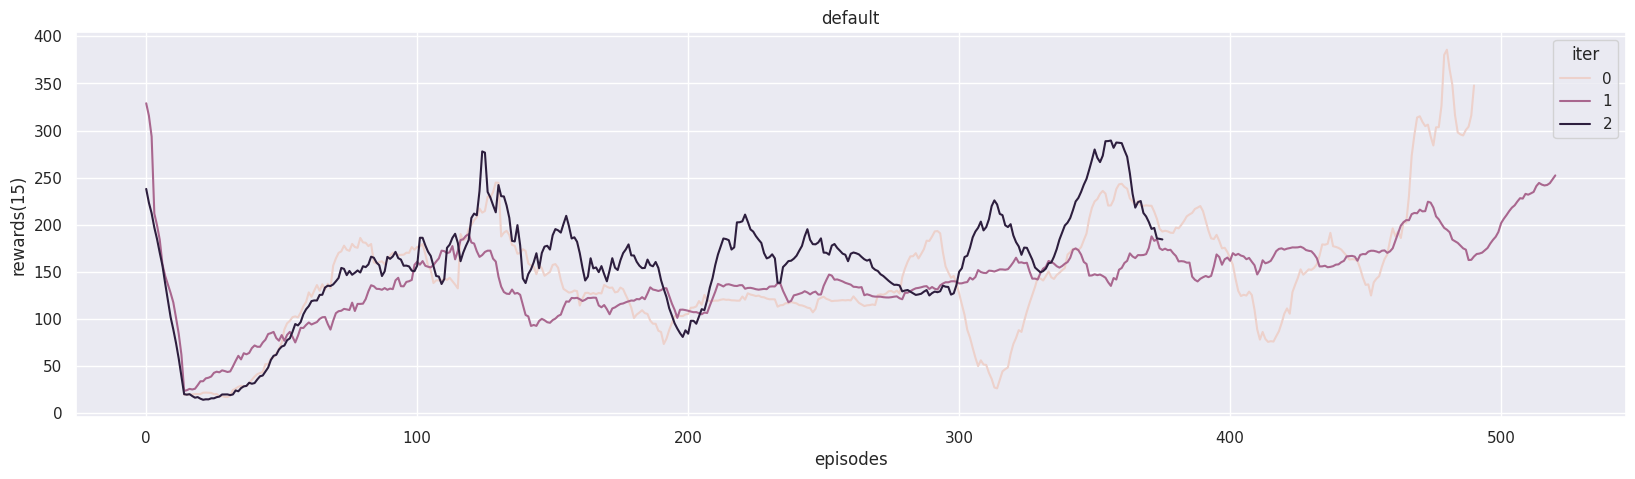

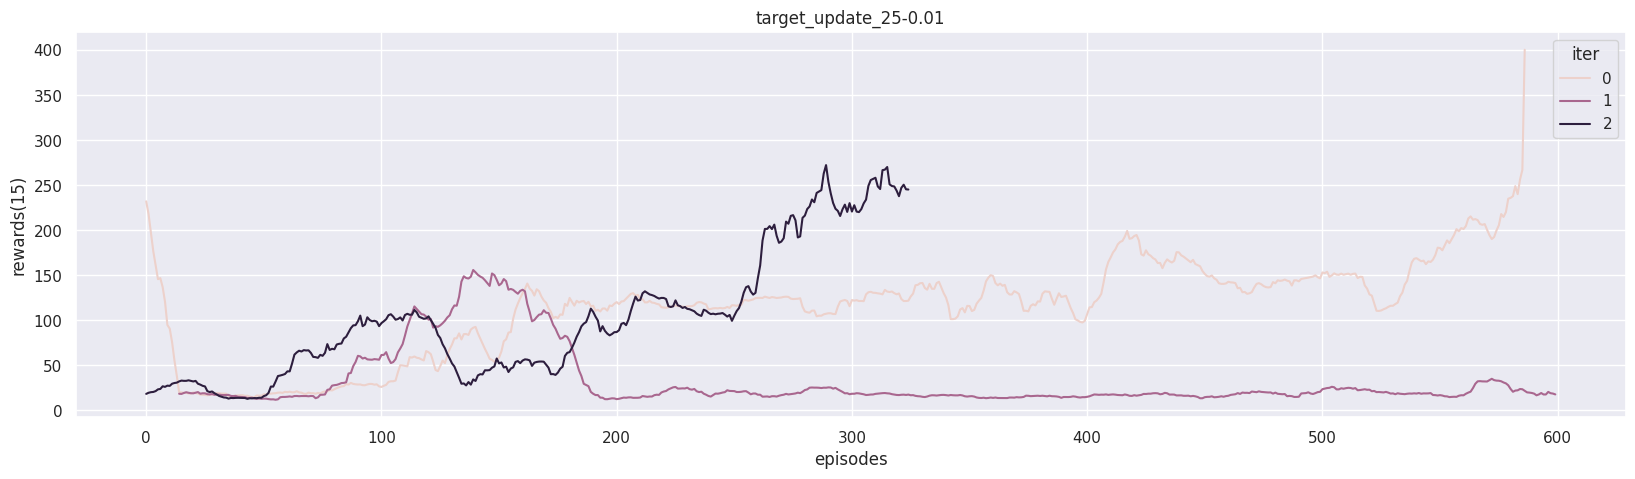

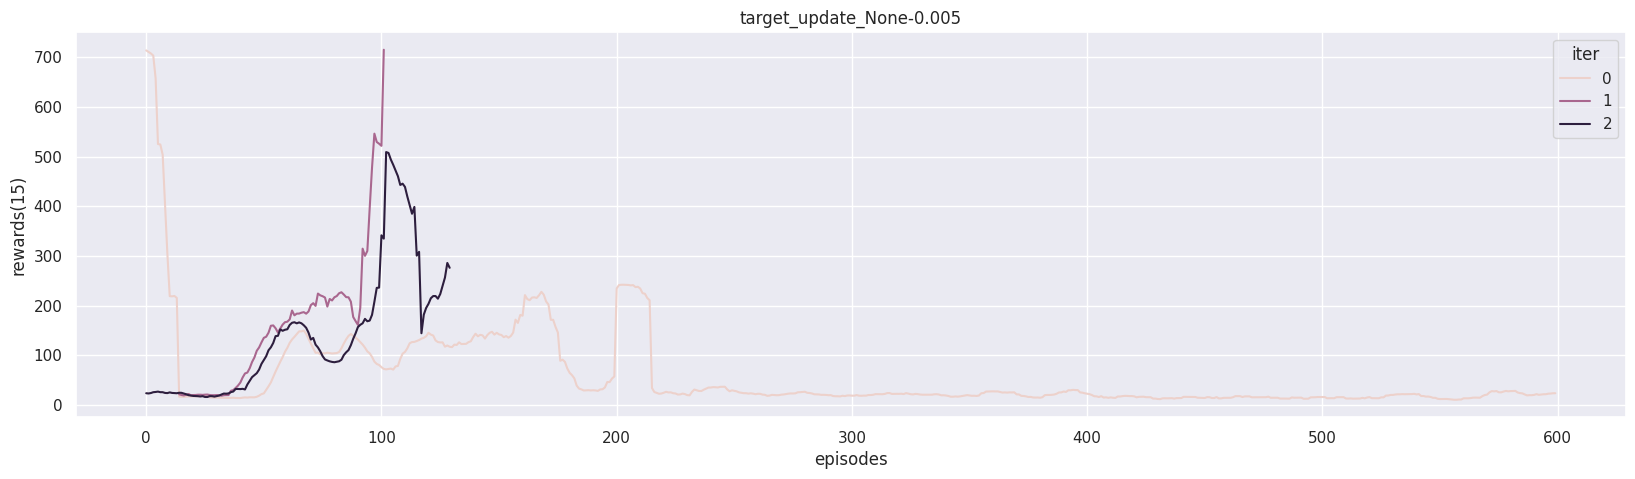

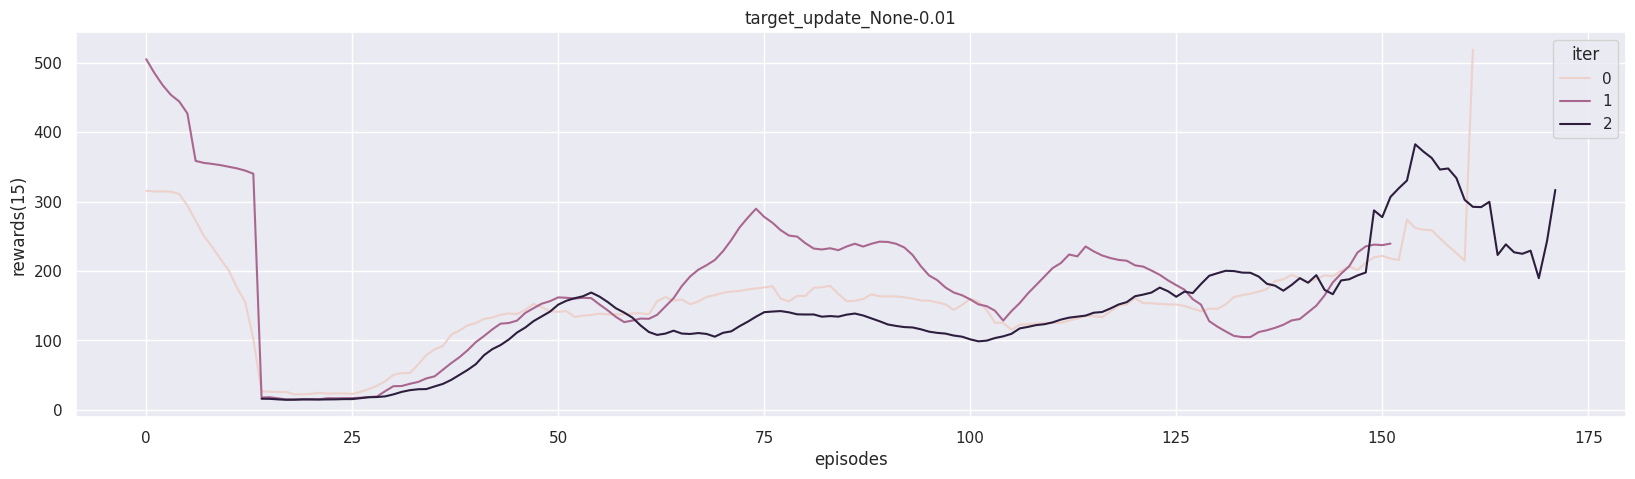

,avg_end_rew,best_worst_ratio_end_rew,avg_epi_rew,avg_epi_rew_increase,std_epi_rew_increase,n_solved,avg_ep_to_solve,max_drawdown
default,392.333,1.794,146.745,0.813,97.890,3.0,462.666667,709.000
target_update_25-0.01,814.333,124.059,81.571,1.588,73.424,2.0,456.000000,245.333
target_update_None-0.005,1081.000,110.000,83.988,3.824,350.707,2.0,116.000000,1815.667
target_update_None-0.01,2080.000,19.828,157.397,12.824,256.466,3.0,162.000000,635.333


In [9]:
params = [x for x in stats_df.index if x.startswith('target_') or x=='default']
stats = stats_df.loc[((stats_df.index.isin(params)) | (stats_df.index=='default')),:]
for param in params:
    df = results_dfs[param]
    df = creage_avg(df,'rewards',15)
    sns_lineplot(df, 'episodes', 'rewards(15)', 'iter', param)
stats

From the table above, the first parameter controls every how many episodes we hard-copy the weights from our policy network to our target network. If this parameter is set to None, then the agent uses a soft update to the target network. That means the new target weights are a weighted average of the new weights (from the policy network) and the old weights of the target network. The second number in that param controls the weight assigned to the new weights. Thus, 0.01, means that the target network weights will be 99% the previous ones + 1% the new ones.

Default settings are (10, 0.01). Key observations:
1. In the hard copy setting, first two rows in the table above, a higher cadency in the copy (25 vs 10 default) does not seem to generate a more robust learning (only two iterations can solve the environment vs 3 in the default setting). The velocity of the learning does not change either, with an avg_ep_to_solve pretty similar in both configurations.
2. The soft update settings does seem to provie an edge. If we compare the velocity at which the agent is able to solve the environment, one can see how the environment is solved nearly with 1/3 of the episodes needed for the hard copy configurations (see avg_ep_to_solve above). Concretely, one can see that the most robust/steady learning process of all studied configurations is found with the parameters target_update_None-0.01, i.e assigning the target networks weights to 99% of the previous ones and 1% to the new ones.

### Learning rate analysis ###

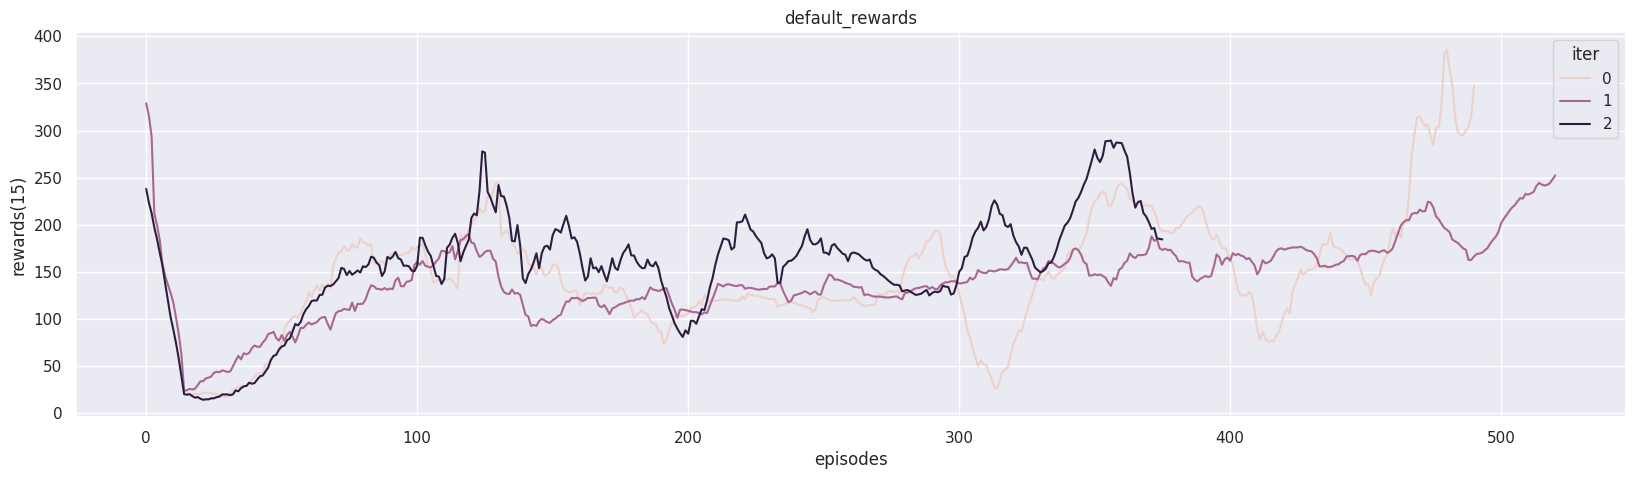

ValueError: Could not interpret value `losses(15)` for `y`. An entry with this name does not appear in `data`.

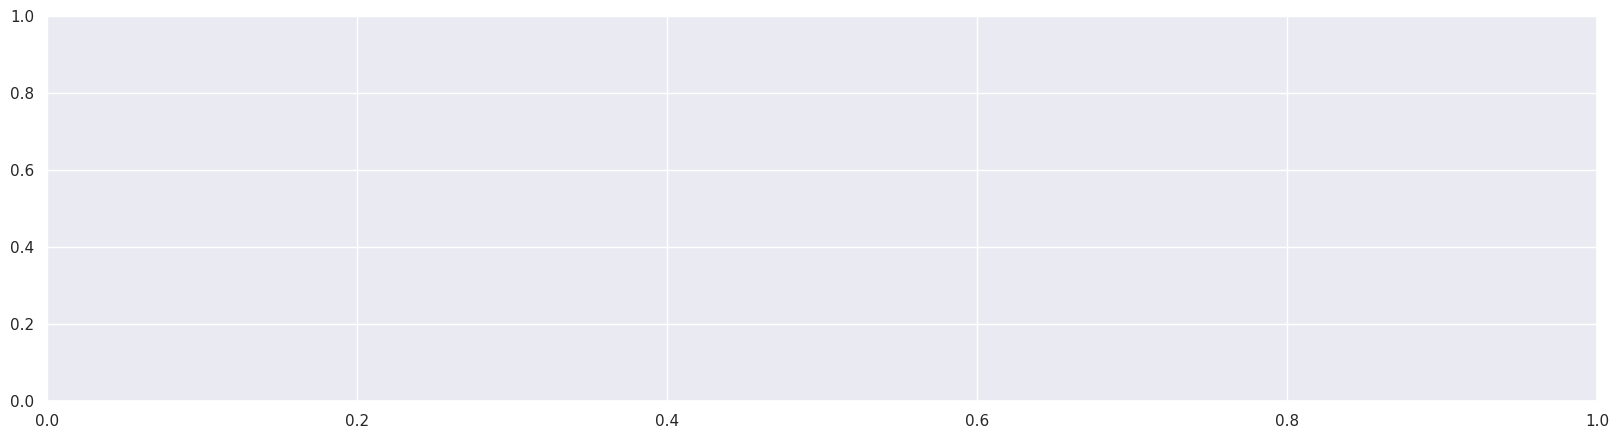

In [10]:
params = [x for x in stats_df.index if x.startswith('lr_') or x=='default']
stats = stats_df.loc[((stats_df.index.isin(params)) | (stats_df.index=='default')),:]
for param in params:
    df = results_dfs[param]
    df = creage_avg(df,'rewards', 15)
    df = creage_avg(df,'losses', 25)
    sns_lineplot(df, 'episodes', 'rewards(15)', 'iter', f'{param}_rewards')
    sns_lineplot(df,'episodes','losses(25)', 'iter', f'{param}_losses')
stats

In this section we've played with different learning rates used for the optimizer, ADAM in our case. This single parameter is probably the one with the strongest effect in the output of our agent. Note how changing this parameters yields to agents being unable to solve the environment, an effect we did not observe until this point. A value too large for this parameter will unable our network to find a minimum for the cost function, leading to poor estimates/decisions. Nevertheless, a value too small will make our learning very inefficient, as our cost function will take very long to get reduced. Since I considered the default parameter to be already quite low, I've only experiment with higher values of learning rates.

Default setting uses a 0.005 learning rate. Key observations:
1. Well parametrized RL problems exhibit a loss profile similar to the 'default' settings figure above, in which losses are never fully minimized. This is an expected phenomena arising from the fact that our target values, estimated by the target network, are dynamic and maximized (remmeber we are choosing the action that delivers the max q_value). This phenomenom is know as "overestimation" of q-values, well documented in research literature for DDQN agents. Both experiments with learning rates of 0.1 and 0.05 lead to poor results, with none of the trials being able to solve the environment, i.e not finding the right policy. Both configurations show agents that are unable to find a systemic strategy to increase rewards.